Primero importemos paquetes pertinentes.

In [2]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

Trabajemos con hidruro de litio (LiH).

In [4]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}' #Def. molecula LiH donde {} significa que el parámetro a variar es la distancia interatómica en la dirección Z   
distances = np.arange(0.5, 4.25, 0.05)  #Se variará dicha distancia desde 0.5A->4.25A en pasos de 0.25A

#Defs. de arreglos para guardar las energías calculadas

vqe_energies = []  #Energias del estado base calculadas mediante VQE
hf_energies = []  #Energías del estado base calculadas del ansatz, sin optimizar
exact_energies = []  #Energías del estado base calculadas mediante NumPyMinimumEigensolver (clásico)

In [5]:
#Loop que correr sobre las diferentes distancias
for i,d in enumerate(distances):
    print('step',i)
    
    #Experimento
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g') #Se calculan la energía de cada distancia.
                                                              #STO-3G describen los orbitales electrónicos de la molécula
    qmolecule = driver.run()  #Corre el driver
    operator = Hamiltonian (qubit_mapping=QubitMappingType.PARITY,  #Hamiltoniano del sistema, mapeado con funciones de qiskit
                            two_qubit_reduction=True, freeze_core=True, #Trucos para mejorar el cálculo. Sólo se considera las bandas de valencia
                            orbital_reduction=[-3,-2])  
    qubit_op, aux_ops = operator.run(qmolecule)
    
    #Resultados clásicos exactos
    exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run() #Se corre NumPy...
    exact_result = operator.process_algorithm_result(exact_result) #Se obtienen los cálculos
    
    #VQE 
    optimizer = SLSQP(maxiter=1000)  #Def. del optimizador estableciendo un número máximo de 1000 iteraciones
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],  #Def. del ansatz
                               operator.molecule_info['num_particles'],
                               qubit_mapping=operator._qubit_mapping,
                               two_qubit_reduction=operator._two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'], #Aplicación de la variación utilizando UCCSD
                    num_particles=operator.molecule_info['num_particles'],
                    initial_state=initial_state,
                    qubit_mapping=operator._qubit_mapping,
                    two_qubit_reduction=operator._two_qubit_reduction)
    algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)  #Algoritmo cuántico-clásico VQE
    
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))  #Se obtienen los cálculos
    vqe_result = operator.process_algorithm_result(vqe_result)
    
    #Llenado de energías calculadas
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy) 
    exact_energies.append(exact_result.energy)

step 0


<ipython-input-5-5c4f69d16da9>:9: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian (qubit_mapping=QubitMappingType.PARITY,  #Hamiltoniano del sistema, mapeado con funciones de qiskit
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after 

step 1


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 2


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 3


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 4


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 5


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 6


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 7


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 8


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 9


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 10


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 11


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 12


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 13


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 14


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 15


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 16


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 17


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 18


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 19


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 20


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 21


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 22


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 23


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 24


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 25


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 26


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 27


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 28


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 29


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 30


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 31


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 32


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 33


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 34


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 35


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 36


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 37


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 38


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 39


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 40


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 41


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 42


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 43


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 44


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 45


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 46


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 47


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 48


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 49


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 50


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 51


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 52


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 53


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 54


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 55


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 56


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 57


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 58


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 59


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 60


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 61


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 62


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 63


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 64


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 65


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 66


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 67


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult

step 68


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 69


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 70


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 71


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 72


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 73


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

step 74


/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/home/cliente/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and wil

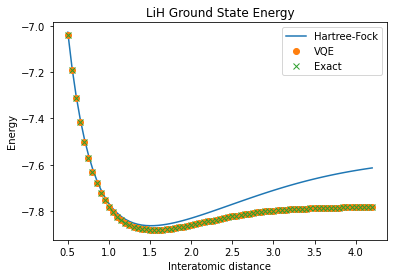

In [6]:
#Plots
pylab.plot(distances, hf_energies, label='Hartree-Fock')
pylab.plot(distances, vqe_energies,'o', label='VQE')
pylab.plot(distances, exact_energies,'x',  label='Exact')

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right')
pylab.savefig('lih.jpeg')